# Exploring Spatial Gene Expression Patterns in the Mouse Brain

# Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Names

- Aditi Sadwelkar
- Aparajita Pranjal
- Benjamin Xue
- Guantong Zhang
- Uyen Tran

# Abstract

The evaluation of gene expression and its relation to spatial data is a topic that is highly relevant in Neurobiology. We want to determine which pairs of genes and cell coordinates have high levels of co-expression. Finding these patterns of co-expression will give us insights about how spatial location of cells is related to gene expression and can affect the function of genes.

To accomplish this, we implement clustering and regression techniques to find relationships and patterns within a dataset of mouse brains. The dataset contains the different genes and cell coordinates present within a single mouse brain. We analyzed 3 relationships within our data: gene expression with other cell samples, gene expression with other genes, and gene expression with other spatial coordinates of the cells. We used a correlation matrix to find which gene pairs are highly-coexpressed and compared with the expression patterns of gene location pairs that were found through k-means clustering.

From these correlation matrix heatmaps, we found that there exists both patterns of high co-expression and spatial correlation between genes epha3 and gfap, as there exists a high level of co-expression between both genes, as well as the genes sharing similar coordinates. A similar pattern can be shown in sox2 and lef1. This gives us some insight about how these two genes can both be related in terms of neural development.

# Research Question

To what extent does 3D spatial transcriptomics on a mouse brain dataset reveal the interplay between gene expression patterns and the spatial distribution of cells? Furthermore, how do co-expression patterns in gene pairs within this spatial context correlate with both the spatial distribution and functional roles of the involved genes?

## Background and Prior Work

Spatial transcriptomics is a technique that allows scientists to visually analyze a tissue sample and map regions within it where gene expression is detected. Fundamentally, the method aims to count the number of transcripts of a gene at specific locations, thus connecting specific cell activity to phenotypic expression. The technique allows for researchers to pinpoint cell-to-cell interactions and how cell organization plays a part in gene expression, which can be particularly useful in potentially tracing disorders to specific locations of cellular malfunction in the body. The dataset we wish to analyze contains a few million cell spatial transcriptomics that map to an entire adult mouse brain, so we hope to gain insight into mouse brain function based on this data.

Gene co-expression networks represent genes and their connection to other genes based on co-expression relationships.<a href="cite_note-1"></a>[<sup>1</sup>](#cite_ref-1) This allows for clustering of genes to identify patterns of similar gene expression patterns. We will take a similar approach to answer our research question in which we use k-means clustering to identify any gene pairs that exhibit co-expression patterns. Prior work has expressed how RNA-seq can be used to construct co-expression networks through retrieving co-expression genes from RNA-seq data. Some common techniques for co-expression clustering are Weighted Gene Correlation Network Analysis (WGCNA). This clustering technique uses hierarchical clustering and correlation networks to separate co-expression genes from RNA-seq data. This is similar to the methods we use in which we use k-means clustering as well as correlation networks to visualize and understand co-expression networks found within the genes we analyzed.

Prior work has shown that co-expression can be widespread within single cells<a href="cite_note-2"></a>[<sup>2</sup>](#cite_ref-2) and is often observed between nearby genes, although it can also occur between genes located at long distances from each other on the chromosome. Additionally, many but not the majority of co-expressed genes are composed of functionally related genes.

References:

1. <a name="cite_note-1"></a> [^](#cite_ref-1) van Dam, Sipko, et al. “Gene Co-Expression Analysis for Functional Classification and Gene–Disease Predictions.” OUP Academic, Oxford University Press, 10 Jan. 2017, https://academic.oup.com/bib/article/19/4/575/2888441 
2. <a name="cite_note-2"></a> [^](#cite_ref-2) M. Ribeiro, Diogo, et al. “Shared Regulation and Functional Relevance of Local Gene Co-Expression Revealed by Single Cell Analysis.” Nature News, Nature Publishing Group, 26 Aug. 2022, https://www.nature.com/articles/s42003-022-03831-w


# Hypothesis


The spatial organization of gene expression within the mouse brain dataset will demonstrate significant correlations with the spatial distribution of cells. Additionally, we hypothesize that co-expression patterns in gene pairs within this spatial context will exhibit correlations with both the spatial distribution and functional roles of the involved genes.

# Data

## Data overview

Dataset #1

Dataset Name: Expression Matrices: MERFISH spatial transcriptomics dataset of a single adult mouse brain (Zhuang-ABCA-1)

Link to the dataset: https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/expression_matrices/Zhuang-ABCA-1/20230830/Zhuang-ABCA-1-raw.h5ad

Number of observations: 4167870

Number of variables: 1122


Dataset #2

Dataset Name: MERFISH spatial transcriptomics dataset of a single adult mouse brain (Zhuang-ABCA-1) - CCF Coordinates

Link to the dataset: 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/metadata/Zhuang-ABCA-1-CCF/20230830/ccf_coordinates.csv'

Number of observations: 2616328

Number of variables: 5

The first dataset (Expression Matrices) contains information about different gene expression levels in a matrix format. This is important to relate with location to identify the cell types.

The second dataset (CCF Coordinates) contains cell labels and x, y, z variables that represent the x, y, z coordinates generated by rotating each section so that it is upright with a midline approximately in the middle of the frame. The parcellation_index represents the parcellation which divides the brain into functional or structural regions.

## Expression Matrices: MERFISH spatial transcriptomics dataset of a single adult mouse brain (Zhuang-ABCA-1-raw)

In [155]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import plotly
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from sklearn.cluster import AgglomerativeClustering

In [3]:
def write_to_file(url):
    local_filename = 'temp_h5ad_file.h5ad'
    response = requests.get(url)
    with open(local_filename, 'wb') as f:
        f.write(response.content)
    return local_filename

In [4]:
def open_h5ad(local_filename, remove=False):
    file = sc.read_h5ad(local_filename)
    if remove:
        os.remove(local_filename)
    return file

First, we want to download the dataset. This may take several minutes.

In [5]:
# Download data
local_filename = write_to_file('https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/expression_matrices/Zhuang-ABCA-1/20230830/Zhuang-ABCA-1-raw.h5ad')
data = sc.read_h5ad(local_filename, remove=True) # remove=False if you want to keep the file

Noticed that we see many zeroes in the matrix, which means that a gene is not expressed in that cell. Therefore, we can plot a histogram to see how many genes are expressed in all the cells.

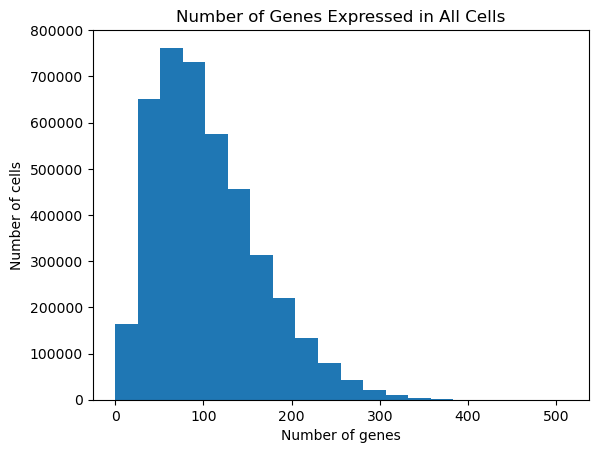

In [72]:
df = data.X
num_zero = [(df[x] == 0).sum() for x in range(df.shape[0])]

num_nonzero = df.shape[1] - np.array(num_zero)
plt.hist(num_nonzero, bins=20)
plt.title('Number of Genes Expressed in All Cells')
plt.xlabel('Number of genes')
plt.ylabel('Number of cells')
plt.show()

Since many of the cells in our dataset only have few gene expressions that we are interested in, we would like to filter these cells out and keep only cells in which at least 25% of the 1122 genes present. After filtering, there are 36,644 cells left.

In [111]:
# Filter to (36644, 1122)

filter_condition = np.array(num_zero) < 0.75*1122
df = df[filter_condition]

Then, we will to add the cell labels to each cell, and change the name of each column to be the symbols of genes.

In [112]:
# Add labels
labels = data.obs.reset_index()['cell_label']
filtered_labels = labels[filter_condition]
df_with_label = np.hstack((df, np.expand_dims(filtered_labels, axis=1)))

# Make it a dataframe
gene_expression = pd.DataFrame(df_with_label)

# Name all columns
gene_symbols = np.array(data.var['gene_symbol'])
gene_expression.columns = np.append(gene_symbols, 'cell_label')


We found the overall distribution of the cell expression levels for each gene. We plotted a histogram of the distribution by taking the average of all cell expression levels for each gene.

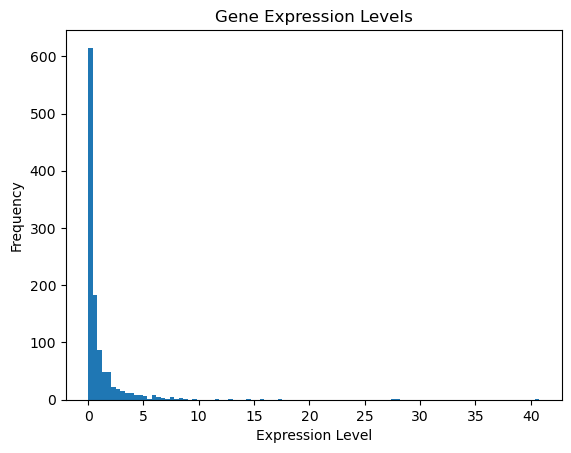

In [159]:
gene_expression.mean()[:-1].plot(kind='hist', bins=100)
plt.title('Gene Expression Levels')
plt.xlabel('Expression Level')
plt.show()

In [113]:
gene_expression

,Htr7,Gzmk,Arhgap36,Sema3c,Rxrg,Itga8,Glp2r,Ramp3,Car12,Chn2,...,Kcnh8,Pifo,Epb41l4a,Matn2,Gata3,Fat1,Zim1,Lmo1,Cntnap3,cell_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,106876524811792393590548649765276574861
1,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,238476362307450023414663573465563612537
2,3.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,7041489245767234511834250940964126613
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68154293602413479071581797473582912500
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,78568185442834002610863521603136276805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36639,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,22.0,...,0.0,0.0,0.0,1.0,2.0,5.0,1.0,0.0,0.0,134696434133107356839648168034363370443
36640,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,135674891142203560149888775643529320871
36641,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,0.0,0.0,1.0,0.0,4.0,0.0,4.0,0.0,119242661520660505558509597501511995761
36642,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,319610769749496587101622738636973953759


## CCF Coordinates: MERFISH spatial transcriptomics dataset of a single adult mouse brain (Zhuang-ABCA-1)

We need to download the dataset. Again, this may take few minutes.

In [42]:
spatial_coordinates = pd.read_csv('https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/metadata/Zhuang-ABCA-1-CCF/20230830/ccf_coordinates.csv')

Now we are able to join the two datasets on cell_label. Since we need the information from both datasets for each single cell, we will use inner join.

In [53]:
final_coords = pd.merge(gene_expression, spatial_coordinates, on='cell_label', how='inner')
final_coords.head()

,Htr7,Gzmk,Arhgap36,Sema3c,Rxrg,Itga8,Glp2r,Ramp3,Car12,Chn2,...,Gata3,Fat1,Zim1,Lmo1,Cntnap3,cell_label,x,y,z,parcellation_index
0,3.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,1.0,1.0,7041489245767234511834250940964126613,6.696238,5.395942,1.814225,942
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,31800441642580142470922095517546483467,7.957887,3.942131,0.934210,227
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,249856719740709542955978123482595126122,7.402969,5.166167,1.447800,134
3,5.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2.0,0.0,0.0,4397563594427321944035322388937694038,7.510285,3.681233,1.017480,1012
4,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,205330313421135828667705619692756006293,7.498582,3.843829,0.928135,227


# Results

## Exploratory Data Analysis

## Clustering of Genes

Then, we will select half of the most expressed genes.

In [121]:
column_totals = gene_expression.sum(axis=0)[:-1]

sorted_columns = column_totals.sort_values(ascending=False)

top_half_columns = sorted_columns.head(len(gene_expression.columns) // 2)

selected_columns = top_half_columns.index.tolist()

top_half_genes = gene_expression[selected_columns]

We want to add the total number of expression levels across each gene. Now we can cluster the genes based on the levels present in the data.

In [122]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(top_half_genes.T)

clustered_data = top_half_genes.iloc[:, np.argsort(cluster_labels)]
clustered_data = clustered_data.iloc[np.argsort(clustered_data.index)]

/Users/zgt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [123]:
gene_totals = clustered_data.sum(axis=0)

# Sort genes based on their total expression
sorted_genes = gene_totals.sort_values(ascending=False)

# Select the top 100 most expressed genes
top_100_genes = sorted_genes.head(100).index

# Filter the DataFrame to include only the top 100 genes
top_100_data = clustered_data[top_100_genes]

In [141]:
top_100_data = top_100_data.astype(float)

To examine the genes exhibiting the highest expression levels, we construct a heatmap of the top 100 most expressed genes. We see a possible pattern: genes positioned at the left of the heatmap exhibit heightened expression compared to those situated towards the left. Additionally, there are small clusters of activity here and there. However, even after several rounds of filtering, there is still a lot of sparsity in the matrix, making it challenging to pinpoint the specific genes that are most abundantly expressed.

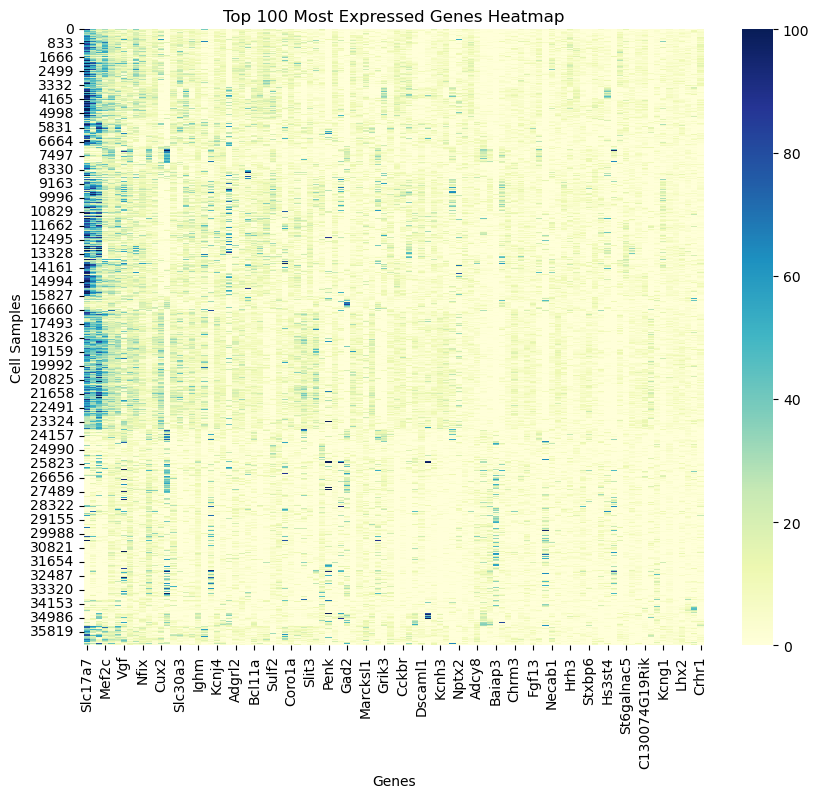

In [143]:
# Define vmin and vmax
vmin = 0.0
vmax = 100.0

plt.figure(figsize=(10, 8))
sns.heatmap(top_100_data, cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title('Top 100 Most Expressed Genes Heatmap')
plt.xlabel('Genes')
plt.ylabel('Cell Samples')
plt.show()

The correlation matrix reveals how highly correlated each gene is to each other. From this next heatmap, we see more orange in the top left corner, suggesting a strong likelihood of correlated gene expression for the genes listed at the top. We can magnify this even further, since it appears that most of the genes do not have high correlation values with the other genes being expressed. 

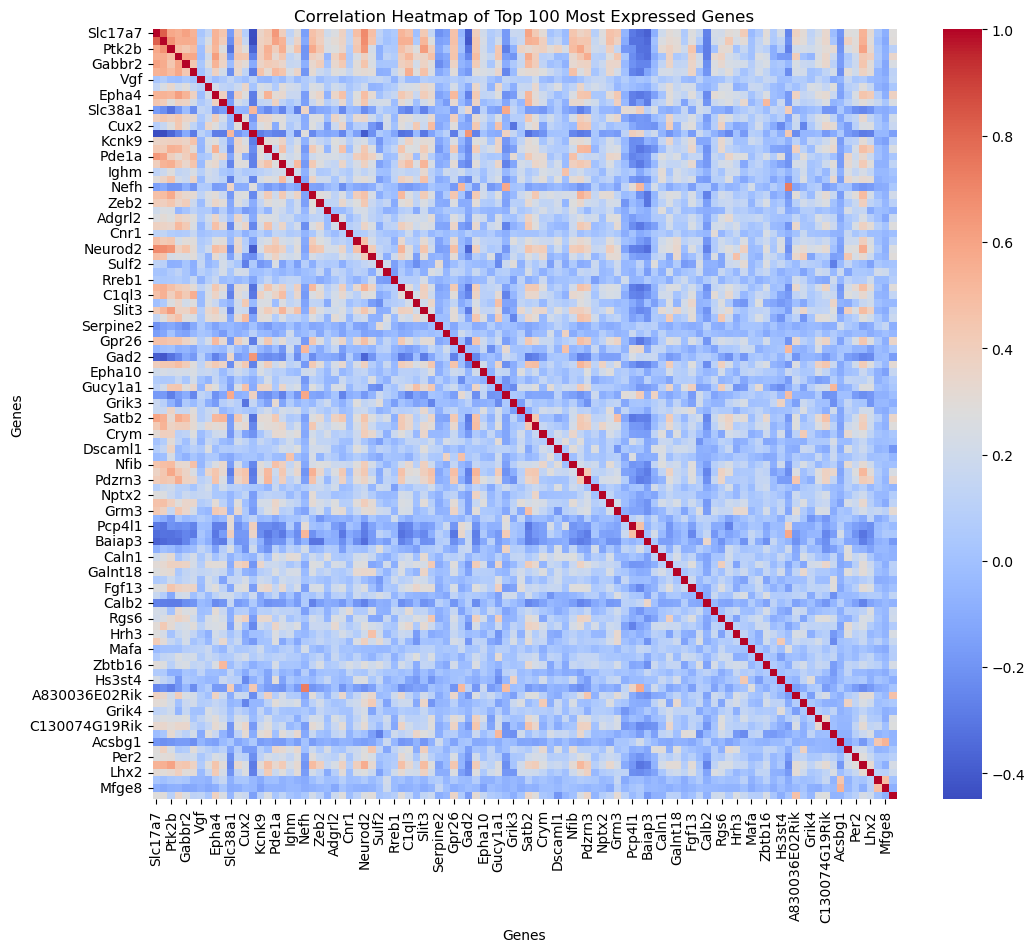

In [144]:
correlation_matrix = top_100_data.corr(numeric_only = False)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Top 100 Most Expressed Genes')
plt.xlabel('Genes')
plt.ylabel('Genes')
plt.show()

For clearer results, we create another heatmap that only shows the expression of the top 25 most expressed genes. This magnifies our data and we can clearly see that the gene 'Slc17a7' is expressed significantly, along with 'Sv2b', and 'Ptk2b'. We also see expression of 'Slc38a1', 'Slc32a1', and 'Nefh' when the formerly mentioned genes are not expressed. 

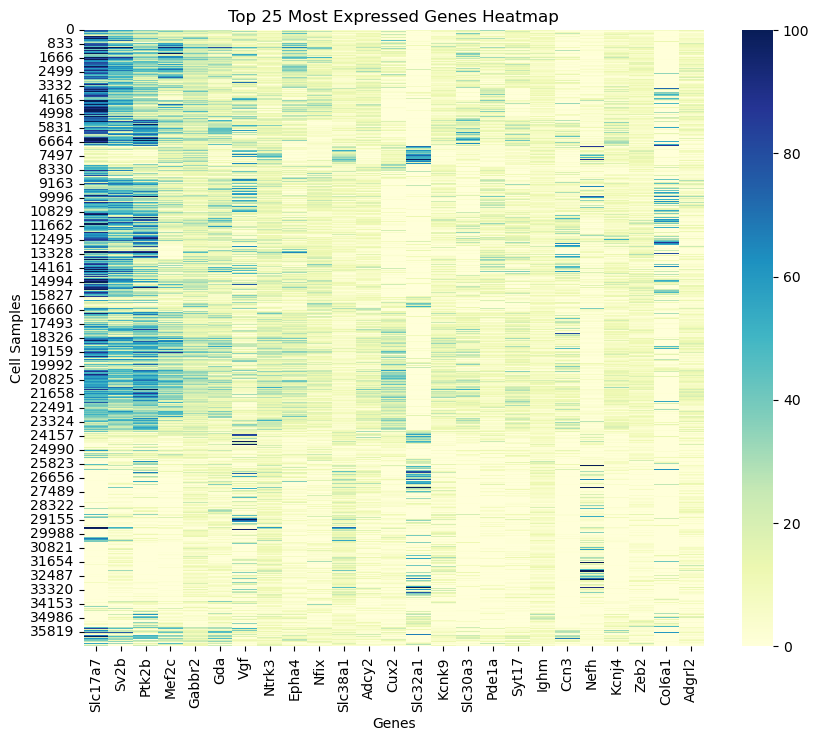

In [147]:
vmin = 0.0
vmax = 100.0

plt.figure(figsize=(10, 8))
sns.heatmap(top_25_data.astype(float), cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title('Top 25 Most Expressed Genes Heatmap')
plt.xlabel('Genes')
plt.ylabel('Cell Samples')
plt.show()

The second correlation matrix more clearly shows a significant correlation between 'Slc17a7' and 'Sv2b' the correlation value being between 0.8 and 1.0. We also see correlation values between 0.4 and 0.8 for 'Ptk2b', 'Mef2c', 'Gabbr2' and 'Gda'. There also seems to be a moderately strong correlation between 'Slc17a7' and 'Sv2b' being expressed and 'Slc32a1' not being expressed (correlation value -0.4) as well as for 'Slc38a1' not being expressed (correlation value between -0.2 and -0.4). 

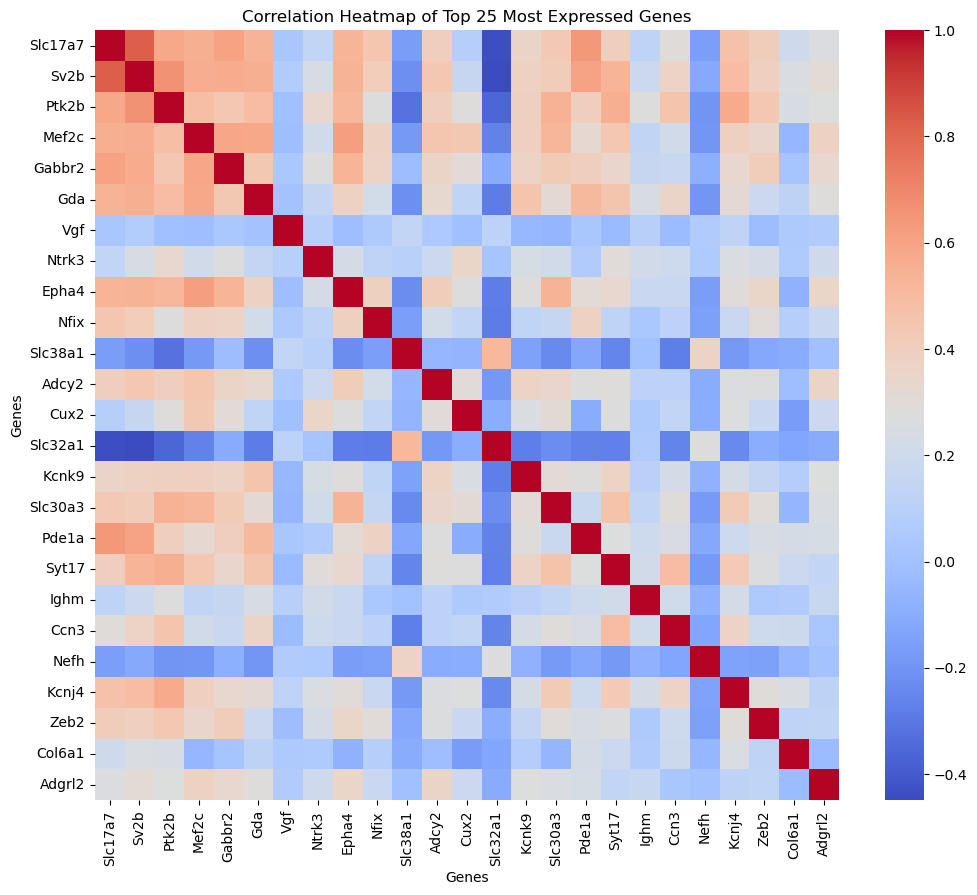

In [150]:
correlation_matrix = top_25_data.corr(numeric_only = False)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Top 25 Most Expressed Genes')
plt.xlabel('Genes')
plt.ylabel('Genes')
plt.show()

This heatmap shows the relationship between the top 25 expressed genes and their spatial coordinates. We see that the values range between 0.3 to -0.5, indicating that there likely isn't a strong relationship between any of the coordinates and the gene expression levels. That being said, we do observe that the correlation values are all closer to the extreme ends of the spectrum for x coordinates (darker hues of orange and blue) and generally closer to 0 for the z coordinates (lighter hues of orange and blue). This suggests that the x coordinate is the most highly correlated to gene expression levels while the z coordinate is the least highly correlated for any of the given genes.

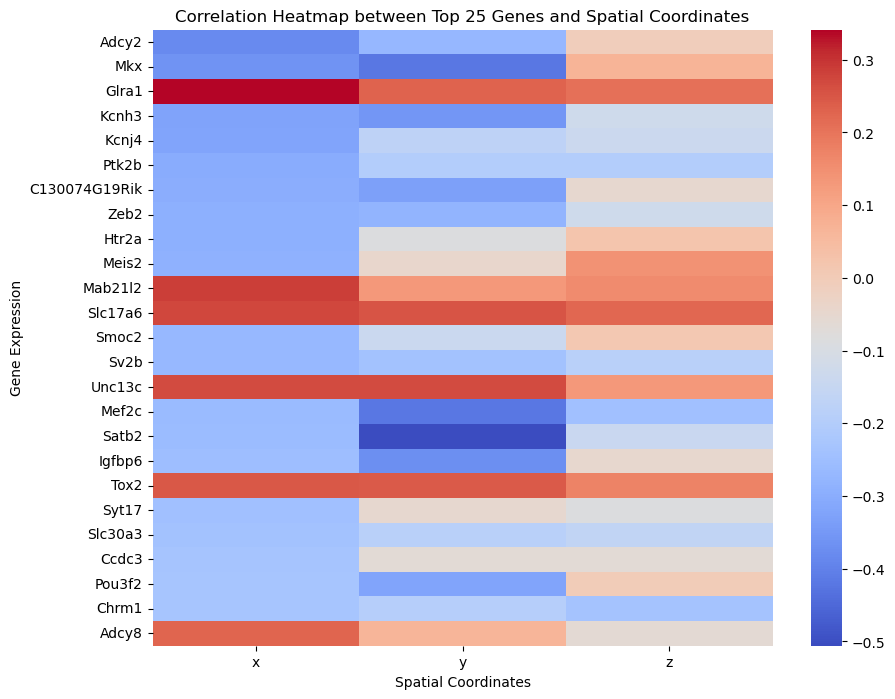

In [151]:
correlation_results = final_coords.corr(numeric_only = False)

# Get the top 25 genes based on their correlation with spatial coordinates
top_25_genes = correlation_results.iloc[:-5]['x'].abs().nlargest(25).index

# Filter the correlation matrix for the top 25 genes and spatial coordinates
correlation_results_filtered = correlation_results.loc[top_25_genes, ['x', 'y', 'z']]

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_results_filtered, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Top 25 Genes and Spatial Coordinates')
plt.xlabel('Spatial Coordinates')
plt.ylabel('Gene Expression')
plt.show()

Looking at the spatial distribution of the cells based on the gene Sox2's expression, we can see why our starting matrix was as sparse as it was. For most of these gene expression slices, the vast majority of cells show no or limited signs of expression level. That being said, we do see some orange spots in certain areas. This is why filtering our matrix was an important step in order to isolate the relevant genes with high expression levels and pinpoint relevant correlations in gene expression based on their spatial coordinates.

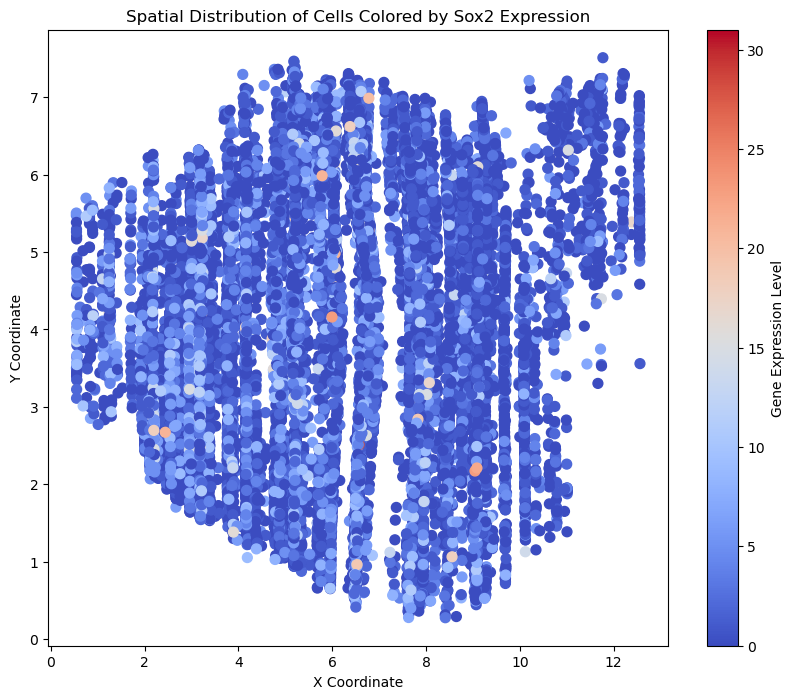

In [154]:
gene_totals1 = clustered_data.sum(axis=0)

# Sort genes based on their total expression
sorted_genes1 = gene_totals.sort_values(ascending=False)

# Select the top 25 most expressed genes
top_25_genes = sorted_genes.head(25).index

# Filter the DataFrame to include only the top 25 genes
top_25_data = clustered_data[top_25_genes]

selected_gene = 'Sox2'

#Extract the spatial coordinates and expression levels for the selected gene
x_values = final_coords['x']
y_values = final_coords['y']
z_values = final_coords['z']
gene_expression_ = final_coords[selected_gene]

#Plot the spatial distribution of cells colored by gene expression
plt.figure(figsize=(10, 8))
plt.scatter(x_values, y_values, c=gene_expression_, cmap='coolwarm', s=50)
plt.colorbar(label='Gene Expression Level')
plt.title(f'Spatial Distribution of Cells Colored by {selected_gene} Expression')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

# Ethics & Privacy

The datasets from mice brains are the most complete with a large number of genes and cell types included. Since they are publically available, there are no privacy concerns associated with the data we would like to analyze. There is full transparency in the animal handling and methods used in the study that follow universal ethical standards.

It's also important to consider that spatial transcriptomics is performed on a single sample, so this may introduce bias and limit the generalizability of findings to other populations as only one gender is sampled at a time (in this case female). The potential omission of information related to the opposite gender could impact the understanding of gene expression levels and functions.

After data analysis, we only confidently explain the results in relation with the female mice brains, but not for male since we don't have enough data to conclude the same. 

van Dam, Sipko, et al. “Gene Co-Expression Analysis for Functional Classification and Gene–Disease Predictions.” OUP Academic, Oxford University Press, 10 Jan. 2017. https://doi.brainimagelibrary.org/doi/10.35077/act-bag

# Discussion and Conclusion

Based on our analysis of the filtered dataset and subsequent exploratory data analysis techniques, including heatmap visualization of correlations of gene co-expression and correlations of gene expression with spatial, as well as principal component analysis (PCA), several genes have emerged as particularly interesting candidates.

Firstly, the genes epha3 and gfap have shown patterns of co-expression and spatial correlation. Both genes are known to play roles in axon growth and migration, and our analysis indicates that they exhibit similar expression patterns and are co-located within the spatial context of the dataset. This suggests a potential functional relationship between epha3 and gfap in regulating axon growth and migration processes.

Similarly, the genes sox2 and lef1 (associated with the Wnt signaling pathway) have demonstrated similarities in their expression profiles and spatial distributions. Both genes are involved in neural development, and our analysis indicates that they exhibit correlated expression patterns and are co-localized within the dataset. This suggests a potential coordinated role for sox2 and lef1 in regulating neural development processes, possibly through the Wnt signaling pathway.

Overall, our findings suggest that genes exhibiting similar expression patterns, functional roles, and spatial distributions may be related and potentially involved in coordinated biological processes within the context of the mouse brain dataset. Further analysis of more gene pairs within this dataset would be even more insightful. After which experimental validation and functional studies will be necessary to confirm these hypotheses for other species and elucidate the precise mechanisms underlying the observed correlations and relationships.


# Team Contributions

We collaborated on the code together. Benjamin worked on the abstract and background sections, Guantong worked on the data overview and processing, Aparajita worked on the discussion and conclusions sections, Aditi worked on the EDA/Results section, and Uyen worked on the Ethics section for our writeup.